# Nếu chưa chia train, test thì load cell này

In [ ]:
import os
import shutil
import random

# Đường dẫn thư mục gốc
DATA_DIR = "/content/data"
TRAIN_DIR = "fingers/train"
TEST_DIR = "fingers/test"

# Tạo thư mục train và test nếu chưa có
for subset in [TRAIN_DIR, TEST_DIR]:
    os.makedirs(subset, exist_ok=True)

# Duyệt qua từng class (0, 1, 2, 3, 4)
for label in range(5):
    class_dir = os.path.join(DATA_DIR, str(label))  # data/0, data/1, ...
    images = os.listdir(class_dir)  # Danh sách ảnh
    random.shuffle(images)  # Xáo trộn dữ liệu

    # Chia train/test (80%-20%)
    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Tạo thư mục lưu ảnh theo class trong train/test
    train_class_dir = os.path.join(TRAIN_DIR, str(label))
    test_class_dir = os.path.join(TEST_DIR, str(label))
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Copy và đổi tên ảnh trong tập train
    for idx, img in enumerate(train_images):
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_class_dir, f"{idx}.png")  # Đặt tên lại theo thứ tự
        shutil.copy(src, dst)

    # Copy và đổi tên ảnh trong tập test
    for idx, img in enumerate(test_images):
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_class_dir, f"{idx}.png")  # Đặt tên lại theo thứ tự
        shutil.copy(src, dst)

print("Chia dữ liệu và đổi tên thành công! 🎉")




# Load Dataset


In [ ]:
import os
import cv2
import glob
import keras
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout

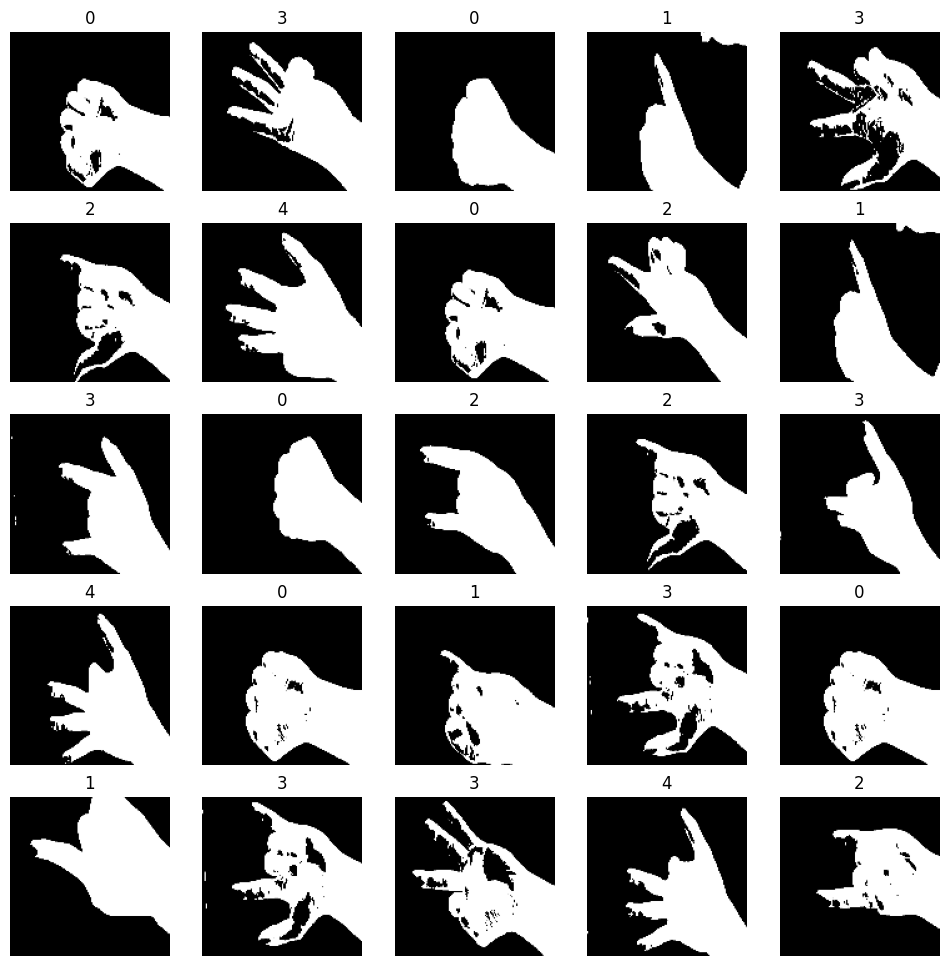

In [ ]:

# Đường dẫn dữ liệu
TRAIN_PATH = '/content/fingers/train'
TEST_PATH = '/content/fingers/test'
IMAGE_SIZE = 128

# Hàm load dataset
def load_dataset(path):
    dataset = []
    for class_folder in glob.glob(os.path.join(path, '*')):  # Duyệt qua từng thư mục con
        if not os.path.isdir(class_folder):  # Bỏ qua nếu không phải thư mục
            continue
        label = int(os.path.basename(class_folder))  # Lấy số từ tên thư mục
        for img_path in glob.glob(os.path.join(class_folder, '*.png')):  # Lấy tất cả ảnh .png
            img = load_image(img_path)  # Load ảnh
            dataset.append((label, img))
    return dataset

# Hàm load ảnh
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Lỗi khi đọc ảnh: {path}")
        return np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)  # Trả về ảnh trắng

    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize ảnh về 128x128
    return img

# Hàm hiển thị nhiều ảnh
def show_images(dataset, grid_size=5):
    _, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = [y for x in axes for y in x]
    for (i, (label, img)) in enumerate(random.sample(dataset, grid_size**2)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

# Load dataset
training_set = load_dataset(TRAIN_PATH)
testing_set = load_dataset(TEST_PATH)

# Hiển thị ảnh
show_images(training_set)


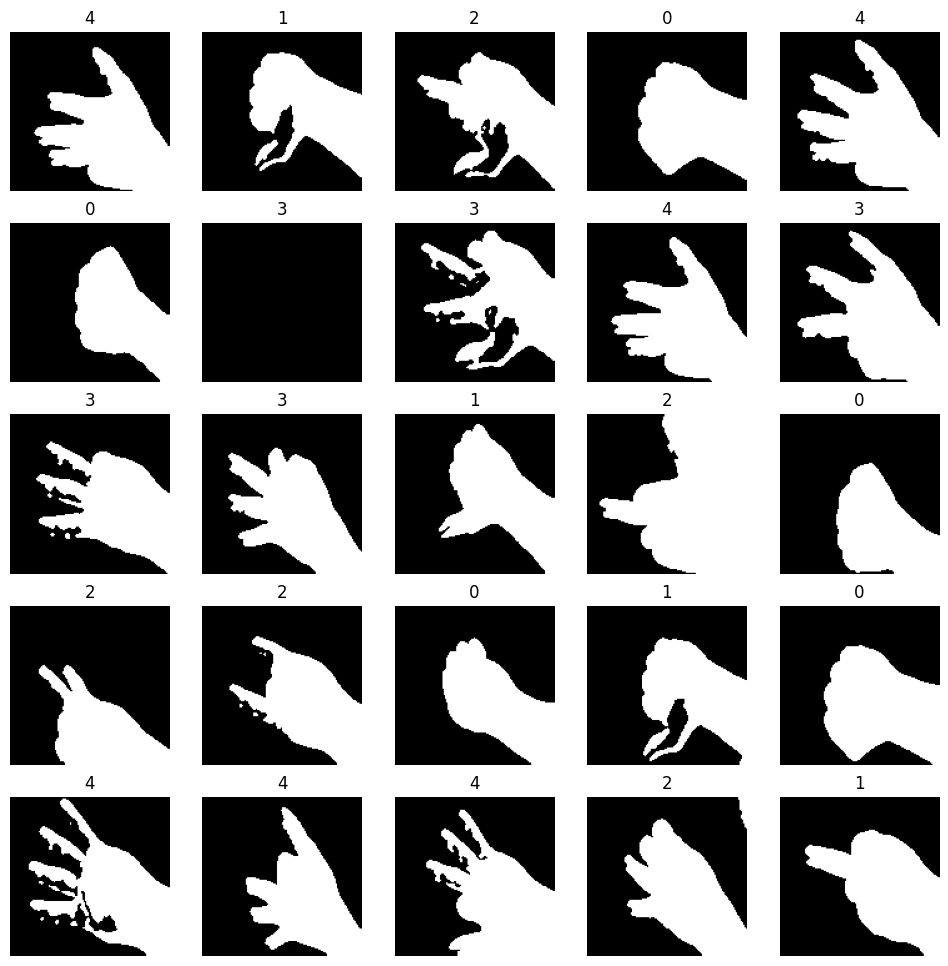

In [ ]:
def process_image(img, thresh_low=50, thresh_high=255):
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    _, img = cv2.threshold(img, thresh_low, thresh_high, cv2.THRESH_BINARY)
    im_floodfill = img.copy()
    h, w = img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    img = img | im_floodfill_inv
    img = img/255
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE, 1))
    return img

def process_dataset(dataset):
    dataset = [(label, process_image(img)) for (label, img) in dataset]
    return dataset

training_set = process_dataset(training_set)
testing_set = process_dataset(testing_set)
show_images(training_set)

## Splitting the dataset in Images and labels

In [ ]:
FILE_NAME = 'realtime_fingers_detection.keras'

KERNEL = (3,3)
CLASSES = 5
IMAGE_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 20

In [ ]:
X_train = np.array([img for (_, img) in training_set])
Y_train = keras.utils.to_categorical([label for (label, _) in training_set], num_classes=CLASSES)
X_test = np.array([img for (_, img) in testing_set])
Y_test = keras.utils.to_categorical([label for (label, _) in testing_set], num_classes=CLASSES)

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(20000, 128, 128, 1)
(20000, 5)


# Model

Generating modified data using the given dataset. We will scale, rotate and transform these images to generate a variety of images for our dataset.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_generator = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)


## Creating the Model

In [ ]:


def get_model():
    input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]

    model = keras.models.Sequential([
            Input(input_shape),
            Conv2D(64, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(128, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(256, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(64, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Dropout(0.2),
            Flatten(),
            Dense(CLASSES, activation="softmax"),
        ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Model Training

In [ ]:
checkpoint = ModelCheckpoint(FILE_NAME, monitor='loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', verbose=1, factor=0.5, patience=1, min_lr=0.0001, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, min_delta=0, restore_best_weights = True, patience=3, mode='min')
callbacks_list = [checkpoint, earlyStopping, reduce_lr]

model = get_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 30, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 64)          │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 6, 6, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │          11,525 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 530,757 (2.02 MB)

 Trainable params: 529,733 (2.02 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
print("Train shape:", X_train.shape, Y_train.shape)
print("Test shape:", X_test.shape, Y_test.shape)
print("Classes:", np.unique(Y_train))


Train shape: (20000, 128, 128, 1) (20000, 5)
Test shape: (5000, 128, 128, 1) (5000, 5)
Classes: [0. 1.]


In [ ]:
# Training the model if the model is not saved
history = model.fit(
        x = img_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
        steps_per_epoch= X_train.shape[0] // BATCH_SIZE,
        validation_data= img_generator.flow(X_test, Y_test, batch_size=BATCH_SIZE),
        validation_steps= X_test.shape[0] // BATCH_SIZE,
        epochs= EPOCHS,
        callbacks= callbacks_list
    )

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5870 - loss: 1.0705
Epoch 1: loss improved from inf to 0.84169, saving model to realtime_fingers_detection.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 36ms/step - accuracy: 0.5871 - loss: 1.0702 - val_accuracy: 0.8185 - val_loss: 0.5142 - learning_rate: 1.0000e-04
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7897 - loss: 0.5729
Epoch 2: loss improved from 0.84169 to 0.53000, saving model to realtime_fingers_detection.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.7897 - loss: 0.5729 - val_accuracy: 0.8622 - val_loss: 0.3884 - learning_rate: 1.0000e-04
Epoch 3/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8368 - loss: 0.4554
Epoch 3: loss improved from 0.53000 to 0.44031, saving model to realtime_fingers_detection.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.8368 - loss: 0.4554 - val_accuracy: 0.8896 - val_loss: 0.3530 - learning_rate: 1.0000e-04
Epoch 4/20

In [ ]:
MODEL_PATH = '/content/realtime_fingers_detection.keras'
model.load_weights(MODEL_PATH)
loss, acc = model.evaluate(X_test, Y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9426 - loss: 0.1516


## Plotting the metrics

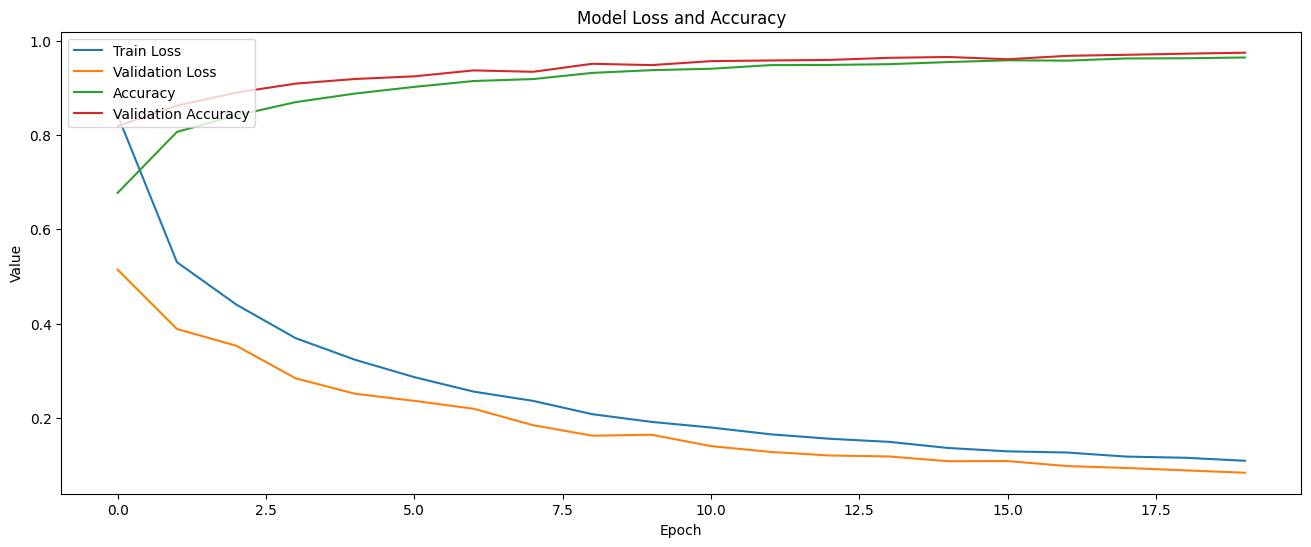

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss', "Accuracy", "Validation Accuracy"], loc='upper left')
plt.savefig('training.png')
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Confusion Matrix:
[[1000    0    0    0    0]
 [   0  983    0   17    0]
 [   0   13  668  308   11]
 [   0    4    0  960   36]
 [   0    5    4    3  988]]
F1 Score: 0.9179519801596189
Accuracy: 0.9198
Loss: [0.20457524061203003, 0.9197999835014343]


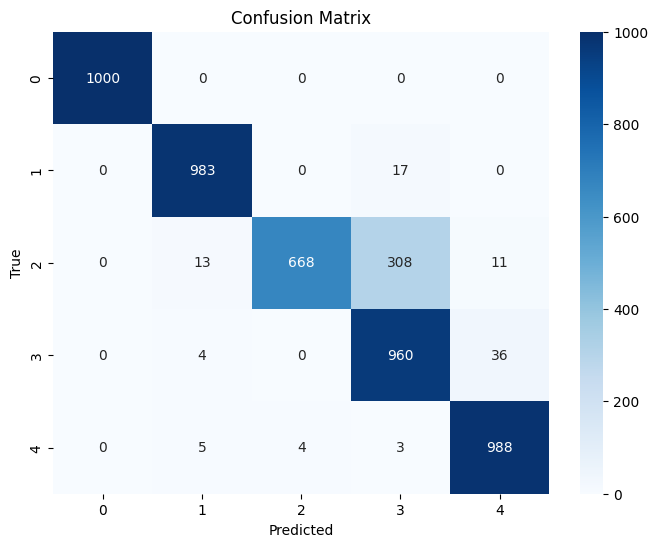

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán với mô hình đã huấn luyện
y_pred = model.predict(X_test)  # Dự đoán kết quả từ mô hình
y_pred_classes = np.argmax(y_pred, axis=1)  # Chuyển dự đoán về dạng lớp (class)

# Convert Y_test if it's in one-hot encoding format
y_true_classes = np.argmax(Y_test, axis=1)  # Convert one-hot labels to class labels

# Tính toán Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Tính toán F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # F1 score theo kiểu weighted

# Tính toán Accuracy
acc = accuracy_score(y_true_classes, y_pred_classes)

# Tính toán Loss (Loss từ mô hình sau khi dự đoán)
loss = model.evaluate(X_test, Y_test, verbose=0)  # Loss từ evaluate

# In các giá trị
print(f'Confusion Matrix:\n{cm}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {acc}')
print(f'Loss: {loss}')

# Vẽ Confusion Matrix (Sử dụng seaborn để dễ nhìn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_classes), yticklabels=np.unique(y_true_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#Loading the model trong jupyter bằng realtime
